# Full-waveform inversion (FWI) solver using automated differentiation

Full-waveform inversion (FWI) is a technique in general employed to estimate the physical parameters in a subsurface region. It is a wave-equation-based seeking an optimal match between observed and computed data. The former is recorded by receivers in a real case. The latter consists of a computed data, which is obtained by solving numerically a wave equation with an forcing term representing a source of wave emission. 

## Functional to be minimised
A tradicional form to measure the difference between the observed and computed data is given by the functional (Tarantola, 1984): 
$$
    I(u, u^{obs}) = \sum_{r=0}^{N-1} \int_\Omega \left(u(c,\mathbf{x},t)- u^{obs}(c, \mathbf{x},t)\right)^2 \delta(x - x_r) \, dx
$$
where $u = u(c, \mathbf{x},t)$ and $u_{obs} = u_{obs}(c,\mathbf{x},t)$, are respectively the computed and observed data, both recorded at a finite number of receivers ($N_r$), located at the point positions $\check{\mathbf{x}} \in \Omega_{0}$, in a time interval $\tau\equiv[t_0, t_f]\subset \mathbb{R}$, where $t_0$ is the initial time and $t_f$ is the final time. The spatial domain of interest is set as $\Omega_{0}$.

An FWI problem consists in finding an optimal parameter $c$ that minimizes the functional $I(u, u^{obs})$.

### Functional implementation
In Firedrake, the functional $I(u, u^{obs})$  is implemented as follows:

In [87]:
from firedrake import *
def functional(self, u_obs, u_computed):
    """Computes the functional J(u) = 0.5 * ||u - u_obs||^2.

    Parameters
    ----------
    u_obs : firedrake.Function
        The observed data at the receivers.
    u_computed : firedrake.Function
        The computed data at the receivers.

    Returns
    -------
    float
        The value of the functional.
    """
    return 0.5 * assemble(inner(u_computed - u_obs, u_computed - u_obs) * dx)
    

## Wave equation
To have the computed data, we need first solve a wave equation. In this example, we consider the scalar acoustic wave equation using a damping term to attenate the reflections originated by the boundaries of the domain.
$$
    \frac{\partial^2 u}{\partial t^2}(\mathbf{x},t)- c^2\frac{\partial^2 u}{\partial \mathbf{x}^2} = f(\mathbf{x}_s,t) \tag{2}
$$
where $c(\mathbf{x}):\Omega_{0}\rightarrow \mathbb{R}$ is the pressure wave ($P$-wave) velocity, which is assumed here a piecewise-constant and positive function. The source term $f(\mathbf{x}_s,t)$ is a function that represents the wave emission. Here, the source of waves is a Ricker wavelet, which is a function of time. 

The wave equation (2) satisfies the boundary conditions:
$$
    u(\mathbf{x},t) = 0, \quad \mathbf{x} \in \partial\Omega_{0}, \quad t\in\tau
$$
The acoustic wave equation should satisfy the initial conditions $u(\mathbf{x}, 0)  = 0 = u_t(\mathbf{x}, 0) = 0$. The domain $\Omega_{0}$ is illustrated at Figure. The boundaries $\partial\Omega_{i}$ with $i = 1,2,3$ are here referred to as truncated boundaries, and satisfy a null-Dirichlet boundary condition $u(\mathbf{x},t) = 0$. The boundary $\Omega_{4}$ satisfies the null-Neumann $\nabla u(\mathbf{x},t) \cdot \mathbf{n} = 0$ (free surface) boundary condition, where $\mathbf{n}$ represents the outward normal (with respect to $\partial \Omega_4$) unit vector.

To solve the wave equation, we consider the following weak form over the domain $\Omega_{0}$:
$$
    \int_{\Omega_{0}} \left(\frac{\partial^2 u}{\partial t^2}v + c^2\nabla u \cdot \nabla v\right) \, dx = \int_{\Omega_{0}} f v \, dx,
$$
for an arbitrary test function $v\in V$, where $V$ is a function space. The implementation of the weak form is given by the following Firedrake code:

In [88]:
import finat
def wave_equation_solver(c, source_function, dt, V):
    """Solves the acoustic wave equation in 2D.

    Parameters
    ----------
    c : velocity field
        The velocity field.
    source_function : firedrake.Function
        The function that models the source of the wave.
    dt : float
        The time step.
    V : firedrake.FunctionSpace
        The function space where the solution lives.

    Returns
    -------
    firedrake.LinearVariationalSolver, firedrake.Function, firedrake.Function, firedrake.Function
        Return the linear variational solver and the functions for the solution at time `n+1`, `n` and `n-1`.
        These outputs are going to be used in a time loop.
    """
    u = TrialFunction(V)
    v = TestFunction(V)

    u_np1 = Function(V) # timestep n+1
    u_n = Function(V) # timestep n
    u_nm1 = Function(V) # timestep n-1

    # quadrature rule for lumped mass matrix
    quad_rule = finat.quadrature.make_quadrature(V.finat_element.cell, V.ufl_element().degree(), "KMV")
    # time discretisation/mass matrix
    m =  (u - 2.0 * u_n + u_nm1) / Constant(dt * dt) * v * dx(scheme=quad_rule)
    # stiffness matrix
    a = c * c * dot(grad(u_n), grad(v)) * dx
    # wave source
    f = source_function * v * dx(scheme=quad_rule)
    F = m + a - f
    lhs_ = lhs(F)
    rhs_ = rhs(F)

    lin_var = LinearVariationalProblem(lhs_, rhs_, u_np1)
    solver = LinearVariationalSolver(lin_var, solver_parameters={"ksp_type": "preonly", "pc_type": "jacobi"})
    return solver, u_np1, u_n, u_nm1

In [96]:
def source_interpolator(parent_mesh, source_location, function_space):
    """Create an interpolator object.

    Parameters
    ----------
    parent_mesh : firedrake.Mesh
        The parent mesh where the source is going to be interpolated.
    source_location : array_like
        The location of the source.
    function_space : firedrake.FunctionSpace
        The function space where the source is going to be interpolated.

    Returns
    -------
    firedrake.Interpolator
        The interpolator object.
    """
    source_mesh = VertexOnlyMesh(parent_mesh, [source_location], redundant=False)
    P0DG = FunctionSpace(source_mesh, "DG", 0)
    P0DG_input_ordering = FunctionSpace(source_mesh.input_ordering, "DG", 0)
    point_data_input_ordering = Function(P0DG_input_ordering)
    point_data_input_ordering.dat.data_wo[:] = 1.0
    f_source = interpolate(point_data_input_ordering, P0DG)
    return Interpolator(TestFunction(function_space), P0DG), f_source

data_coords = np.array(
        [
            [0.0, 0.0],
            [0.0, 0.5],
            [0.0, 1.0],
            [0.5, 0.0],
            [0.5, 0.5],
            [0.5, 1.0],
            [1.0, 0.0],
            [1.0, 0.5],
        ]
    )
def test_vertex_only_mesh_manual_example():
    parent_mesh = UnitSquareMesh(10, 10)

    V = FunctionSpace(parent_mesh, "CG", 2)

    # Create a function f on the parent mesh to point evaluate
    x, y = SpatialCoordinate(parent_mesh)
    f = Function(V).interpolate(x**2 + y**2)

    # 3 points (i.e. vertices) at which to point evaluate f
    points = [[0.1, 0.1], [0.2, 0.2], [0.3, 0.3]]

    vom = VertexOnlyMesh(parent_mesh, points)

    # P0DG is the only function space you can make on a vertex-only mesh
    P0DG = FunctionSpace(vom, "DG", 0)

    # Interpolation performs point evaluation
    f_at_points = assemble(interpolate(f, P0DG))

test_vertex_only_mesh_manual_example()

ERROR: Index_Intersects_id failed in libspatialindex!ERROR: Index_Intersects_id failed in libspatialindex!ERROR: Index_Intersects_id failed in libspatialindex!ERROR: Index_Intersects_id failed in libspatialindex!ERROR: Index_Intersects_id failed in libspatialindex!ERROR: Index_Intersects_id failed in libspatialindex!ERROR: Index_Intersects_id failed in libspatialindex!ERROR: Index_Intersects_id failed in libspatialindex!

VertexOnlyMeshMissingPointsError: 8 vertices are outside the mesh and have been removed from the VertexOnlyMesh.

In [90]:
def ricker_wavelet(time_interval, frequency):
    import numpy as np
    def ricker(time_interval, f):
        return (1.0 - 2.0 * np.pi ** 2 * f ** 2 * (time_interval - 1.0 / (2.0 * f)) ** 2) * np.exp(-np.pi ** 2 * f ** 2 * (time_interval - 1.0 / (2.0 * f)) ** 2)
    return ricker

## Executing an wave equation solver
In this example, we consider a two dimensional domain where we want to estimate the parameter $c$ in a physical domain with the lenght of $1$ km ($L_x = 1km$) and the depth of $1$ km ($L_z = 1km$).

Below we create a dictionary containing the parameters necessary to solve the wave equation.

In [91]:
import numpy as np
Lx, Lz = 1, 1
num_receivers = 10
num_sources = 1
model = {
    "source_locations": np.linspace((0.1, 0.4), (0.1, 0.6), num_sources),
    "receiver_locations": np.linspace((0.3, 0.1), (0.9, 0.1), num_receivers),
    "mesh": UnitSquareMesh(50, 50),
    "dt": 0.001,
    "final_time": 1.0,
    "frequency_peak": 7.0,
    "element_model": {"method": "CG", "degree": 1, "quadrature": "CG"},
}

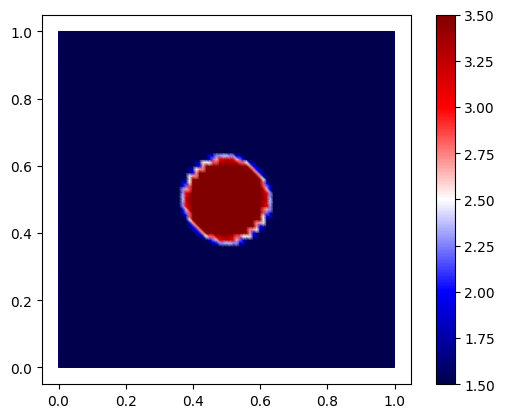

In [92]:
from firedrake.pyplot import tricontourf, tripcolor
import matplotlib.pyplot as plt
def velocity_model(c_computed=False, plot_c=False):
    """Acoustic velocity model"""
    V = FunctionSpace(model["mesh"], model["element_model"]["method"], model["element_model"]["degree"])
    x, z = SpatialCoordinate(model["mesh"])
    if c_computed:
        c = Function(V).interpolate(1.5 + 0.0 * x)
    else:
        c = Function(V).interpolate(2.5 + 1 * tanh(200 * (0.125 - sqrt((x - 0.5) ** 2 + (z - 0.5) ** 2))))
    if plot_c:
        fig, axes = plt.subplots()
        levels = np.linspace(min(c.dat.data_ro), max(c.dat.data_ro), 2)
        contours = tripcolor(c, axes=axes, cmap="seismic")
        axes.set_aspect("equal")
        fig.colorbar(contours)
    return c

c = velocity_model(plot_c=True)

We then simulate the wave equation using the parameters defined in the dictionary as follows:

In [95]:
V = FunctionSpace(model["mesh"], model["element_model"]["method"], model["element_model"]["degree"])
source_function = Function(V)
solver, u_np1, u_n, u_nm1 = wave_equation_solver(c, source_function, model["dt"], V)
time_interval = np.arange(0, model["final_time"], model["dt"])
wavelet = ricker_wavelet(time_interval, model["frequency_peak"])
s_interpolator, f_source = source_interpolator(model["mesh"], model["source_locations"], V)
interpolator_wavelet = Interpolator(f_source, V)
for t in time_interval:
    f_source.dat.data_ro[:] = wavelet(t)
    s_interpolator.interpolate(f_source, transpose=True)
    interpolator_wavelet.interpolate(f_source)
    # Call the solver object.
    solver.solve()
    # Exchange the solution at the two time-stepping levels.
    u_nm1.assign(u_n)
    u_n.assign(u_np1)

ERROR: Index_Intersects_id failed in libspatialindex!ERROR: Index_Intersects_id failed in libspatialindex!

ValueError: too many values to unpack (expected 2)